In [1]:
from Functions import *
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/optimization/


In [4]:
def define_beamline(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 9.0,
    hkl2 = [3,3,3], alphaAsym2 = 0.0,
    hkl3 = [4,4,0], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### Setup beamline and calculate beam profiles at each optics to determine the crystal profiles

In [5]:
##### perfect case
m1_p = 185.0; m2_p = 175.5
slit_width = 1e-1
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [4,4,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


b 0.15
b 6.76
b 1.00
b 1.00
b 1.00
b 1.81
slit width: 100000.0 um
b 0.55
b 1.00
path exists
path exists


In [15]:
dir_plot

'output/9481eV/optimization/2DCM_111_440/9.0_0.0_deg_20.0mm_offset/'

In [6]:
beam_offsets = []
for device in mono_devices:
    print(device.name)
    print('  x:{}, y:{}, z:{}\n'.format(device.global_x, device.global_y, device.z))
    if device.name == 'HHLM1':
        beam_offsets.append(device.global_x)
    if device.name == 'HHLM2':
        beam_offsets.append(device.global_x)

beam_offset = (beam_offsets[-1]-beam_offsets[0])*1e3
print('beam_offset: {}mm'.format(beam_offset, 2))
print('distance factor for 20mm: {}'.format(20/beam_offset))

im_input
  x:0, y:0, z:834

M1
  x:0.0, y:0.0, z:835

im_after_T1
  x:5.3000496262194466e-05, y:0.0, z:835.01

M2
  x:0.6095057070157908, y:0.0, z:950

im_after_T2
  x:0.6095057070157908, y:0.0, z:950.01

HHLM1
  x:0.6095057070157908, y:0.0, z:955

im_after_HHLM1
  x:0.6099526019937439, y:0.0, z:955.001

HHLM2
  x:0.629500629189023, y:0.0, z:955.0447418815587

im_after_HHLM2
  x:0.6295005814874671, y:0.0, z:955.0457418815587

HHLM3
  x:0.6294910888778436, y:0.0, z:955.2447418815588

im_after_HHLM3
  x:0.6156770970741774, y:0.0, z:955.2457418815587

HHLM4
  x:0.6094778407912348, y:0.0, z:955.2461906480247

im_after_HHLM4
  x:0.6094777930896789, y:0.0, z:955.2471906480247

C1
  x:0.6092510766887066, y:0.0, z:960

im_after_C1
  x:0.6230467917466344, y:0.0, z:960.001

C2
  x:1.2990368296007786, y:0.0, z:960.05

im_after_C2
  x:1.2990367544666153, y:0.0, z:960.0509999999999

im_before_MIR1
  x:1.2982855631017969, y:0.0, z:970.049

mir1
  x:1.2982854879676335, y:0.0, z:970.05

im_after_MIR1


In [7]:
%%capture capt
# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]

beta0s = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)

# crystal lengths (long) and widths (short) [m]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2


In [8]:
##### calculate crystal properties to calculate beam power
braggs = []
asyms = []

for device in mono_devices:
    if device.name in crystals:
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
print('beam size[mm]: {}'.format(beam_size*1e3))
print('bragg angle', np.round(braggs,3))
print('asymmetry', asyms)
print('footprint [mm]',l_crystal*1e3/2)

beam size[mm]: [8.85082865 1.31106545 1.31113526 1.31113702 1.30930246 0.72362188]
bragg angle [12.043 12.037 42.928 42.928 42.928 42.928]
asymmetry [-9.0, 9.0, -0.0, 0.0, 0.0, 14.999999999999998]
footprint [mm] [24.656011   24.68185122  1.92507114  1.92507371  1.92238014  1.54489859]


### Calculate slit width

In [9]:
%%capture capt
mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

''' propagate '''
beam_params['photonEnergy'] = E0
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [10]:
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

wx = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2]
slit_width = calc_slit_width(wx*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6:
    slit_width = 3e-6
    
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))


calculated slit width: 3.24um
actual slit width: 3.24um



### load crystal profiles

HHLM1_16.43W_


<ipython-input-11-cbce5c61cda2>:27: RuntimeWarning: divide by zero encountered in true_divide
  ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])


(5637, 2)
(4517, 2)
(4517, 2)
(5637, 2)
(1157, 2)
(1157, 2)


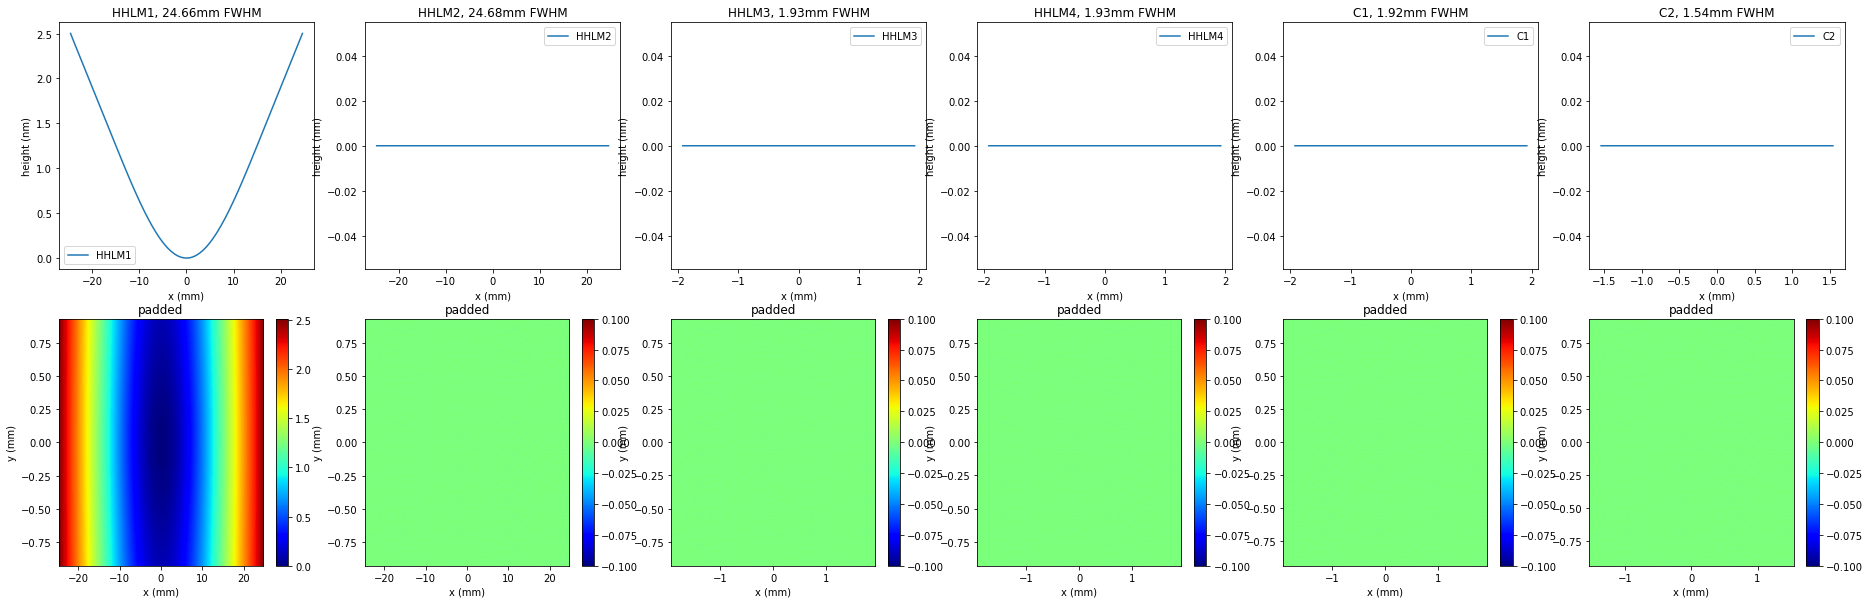

In [11]:
# crystal_powers = np.array([32.86, 10.54, 1.323, 0.091, 0.015, 0.063])
crystal_powers = np.zeros(6); crystal_powers[0] = 32.86/2

# get file name based on crystal powers
for i in range(n_crys):
    if i == 0:
        fname_error = ''
    if crystal_powers[i] != 0:
        fname_error += '{}_{}W_'.format(crystals[i], crystal_powers[i])
print(fname_error)

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/'

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

crystal_profile_powers = np.array([
    [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
    [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
    [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
])

# choose which profile to use based on intended crystal power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])

for i in range(3):
    for j in range(n_crys):
        if ratio_power[i,j] <=1:
            ratio_power[i,j] = 1/ratio_power[i,j]

# pick the most similar case to scale up/down for each crystal
options = []
for i in range(n_crys):
    options.append(ratio_power[:,0].argmin()+1)

for i, crystal in enumerate(crystals):
    # load profiles from file
    num = (options[i]-1)*n_crys + i+1
    dy, xx, zz = load_crystal_data(num, dir_profile)
    
    # change height linearly with power
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    
    # change height linearly with footprint
    height_factor2 = (l_crystal[i]/(xx.max()-xx.min()))*(w_crystal[i]/(zz.max()-zz.min()))*1e6

    shapeErrors[i] = dy * 1e6 * height_factor1 / height_factor2    # shapeErrors in [nm]
    x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, xx.shape[0])
    y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, xx.shape[1])

# # padding
# for i in range(n_crys):
#     shape = shapeErrors[i]
    
#     # crystal length, width and resolutions; crystals are made to have the same size as the shapeError profiles at the moment
#     l_crystal[i] = (x_mirs[i].max() - x_mirs[i].min())*1e-3; dx = (x_mirs[i][1]-x_mirs[i][0])*1e-3
#     w_crystal[i] = (y_mirs[i].max() - y_mirs[i].min())*1e-3; dy = (y_mirs[i][1]-y_mirs[i][0])*1e-3
    
#     # padded dimension
#     size_x_padded = np.int(l_crystal[i]/dx) + 1; size_x_padded = size_x_padded + size_x_padded%2
#     size_y_padded = np.int(w_crystal[i]/dy) + 1; size_y_padded = size_y_padded + size_y_padded%2

#     # padding the out-skirt with maximum heights
#     shapeError_new = np.ones((size_x_padded, size_y_padded)) * shape.max()
#     roi_x_i = int((size_x_padded - shape.shape[0])/2)
#     roi_x_f = roi_x_i + shape.shape[0]
#     roi_y_i = int((size_y_padded - shape.shape[1])/2)
#     roi_y_f = roi_y_i + shape.shape[1]

#     shapeError_new[roi_x_i:roi_x_f, roi_y_i:roi_y_f] = shape.T
#     shapeErrors[i] = shapeError_new.T

##### plots
plt.figure(figsize=(int(5*n_crys)+2, 10))
for i in range(n_crys):
    plt.subplot(2,n_crys, int(i+1))
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend()
    plt.xlabel('x (mm)')
    plt.ylabel('height (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2,n_crys, n_crys+(int(i+1)))
    
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3,
                        y_mirs[i].min()*1e3, y_mirs[i].max()*1e3])
    plt.colorbar()
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title('padded')
    plt.axis('tight')

plt.savefig(dir_plot+'shapeErrors_{}.png'.format(fname_error))

for i in range(n_crys):
    if crystal_powers[i] == 0:
        shapeErrors[i] = None


### M2_p optimization (perfect case)

In [12]:
%%capture capt
n_loop = 31
m2_p = np.linspace(150, 200, n_loop)
pulse_duration = np.zeros_like(m2_p)
pulse_tilt = np.zeros_like(m2_p)
spatial_chirp = np.zeros_like(m2_p)
energy_bandwidth = np.zeros_like(m2_p)
throughput = np.zeros_like(m2_p)

if os.path.exists(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6)):
    print('perfect case already simulated, skipping to plots')
else:
    for i in range(n_loop):
        mono_devices, mono_beamline = define_beamline(E0,
                                   m1_p=m1_p, m2_p=m2_p[i], HHLM_type=HHLM_type,
                                   slit_width=slit_width, f1=f1, f2=f2,
                                   hkl1=hkl1, alphaAsym1=alphaAsym1,
                                   hkl2=hkl2, alphaAsym2=alphaAsym2,
                                   hkl3=hkl3, alphaAsym3=alphaAsym3,
                                   shapeErrors=[None for i in range(6)],
                                   l_crystal=l_crystal,
                                   w_crystal=w_crystal)

        screen_names = ['im_input','im_out']

        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
        c, pulse_duration[i] = pulse.pulse_duration('im_out')
        pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
        spatial_chirp[i] = pulse.spatial_chirp('im_out')
        energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
        throughput[i] = pulse.throughput('im_input','im_out')

    with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'w') as f:
        f.create_dataset('m2_p', data=m2_p)
        f.create_dataset('pulse_duration', data=pulse_duration)
        f.create_dataset('tilt', data=pulse_tilt)
        f.create_dataset('chirp', data=spatial_chirp)
        f.create_dataset('bandwidth', data=energy_bandwidth)
        f.create_dataset('throughput', data=throughput)


output/9481eV/optimization/2DCM_111_440/9.0_0.0_deg_20.0mm_offset/
left 198.33333333333334, right 200.0, result 198.33333333333337


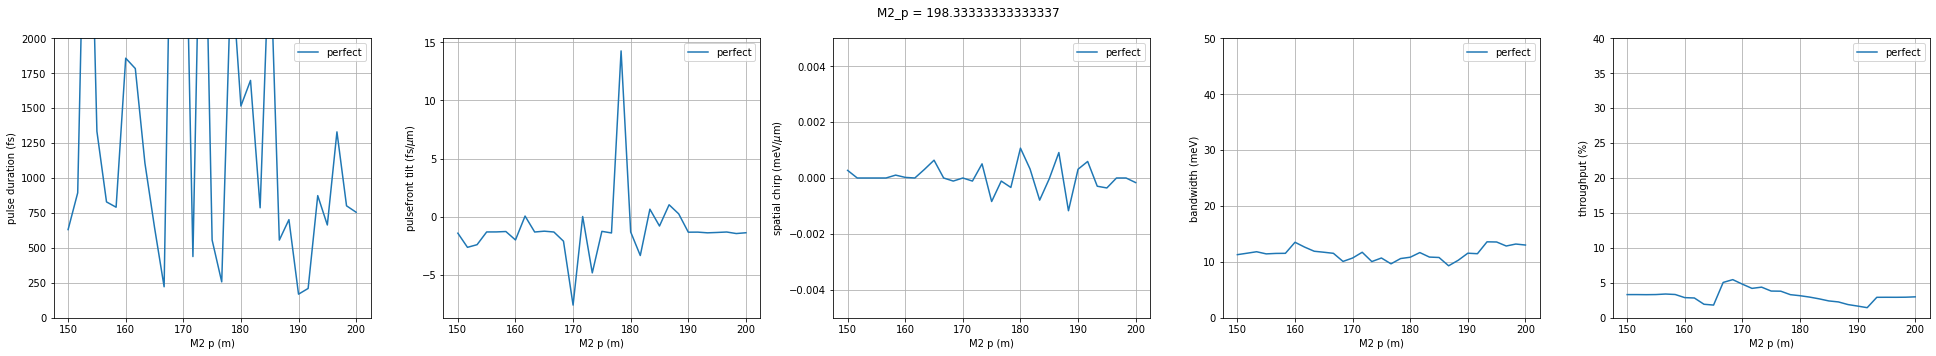

In [13]:
##### m2_p optimization (perfect case)
with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'r') as f:
    m2_p = f['m2_p'][:]
    pulse_duration0 = f['pulse_duration'][:]
    pulse_tilt0 = f['tilt'][:]
    spatial_chirp0 = f['chirp'][:]
    energy_bandwidth0 = f['bandwidth'][:]
    throughput0 = f['throughput'][:]

print(dir_plot)
try:
    result = find_zero(m2_p, spatial_chirp0)
except:
    result = m2_p[energy_bandwidth0.argmin()]

plt.figure(figsize=(27,5))
plt.suptitle('M2_p = {}'.format(result))

plt.subplot(1,5,1)
plt.plot(m2_p, pulse_duration0,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 2e3])

plt.subplot(1,5,2)
plt.plot(m2_p, pulse_tilt0,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,5,3)
plt.plot(m2_p, spatial_chirp0*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-5e-3, 5e-3])

plt.subplot(1,5,4)
plt.plot(m2_p, energy_bandwidth0*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 50])

plt.subplot(1,5,5)
plt.plot(m2_p, throughput0*100,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('throughput (%)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 40])

plt.savefig(dir_plot+'M2_p_optimization.png')


### with shapeErrors

### Plots

In [14]:
import winsound
winsound.Beep(1500, 3000)